In [141]:
import networkx as nx # make sure you installed networkx
import pandas as pd
import numpy as np

In [142]:
# Read in data
df = pd.read_csv("../../data/forwards/forwards_edgelist_corsi.csv")
players_df = pd.read_csv("../../data/forwards/aggregate_forwards.csv", index_col='playerId', header=0)

In [143]:
# Create a network of nodes which are players and the links are players that played together
# We create 2 graphs, one for each relationship direction and then compose them for our total graph
df = df.rename(columns={'cf_inf_on2':'weight'})
G0 = nx.Graph()
G0 = nx.from_pandas_edgelist(df, 'playerId1', 'playerId2', ['weight'],create_using=nx.DiGraph)

df = df.rename(columns={'weight':'notweight','cf_inf_on1':'weight'})
G1 = nx.Graph()
G1 = nx.from_pandas_edgelist(df, 'playerId2', 'playerId1', edge_attr='weight',create_using=nx.DiGraph)

G = nx.compose(G0, G1)

In [144]:
# We are creating this graph specifically for community analysis, so we can clean up irrelevant nodes
# Delete edges with 0 or negative influence
edge_attrs = nx.get_edge_attributes(G, "weight")
for edge in edge_attrs.keys():
    if edge_attrs[edge] <= 0:
        G.remove_edge(edge[0], edge[1])

# Delete nodes with no edges
G.remove_nodes_from(list(nx.isolates(G)))

In [145]:
# Add data to nodes that may be useful for visualization
def copy_attr_to_nodes(G, df, attr_name):
    nodes_dict = dict.fromkeys(G.nodes)
    for node in G.nodes:
        node_attr = df.loc[[node]][attr_name].values[0]
        nodes_dict[node] = node_attr
    return nodes_dict

In [146]:
# Copy a whole bunch of relevant stats to nodes for easier data analysis
# Add player names to nodes
player_names = copy_attr_to_nodes(G, players_df, "playerName")
nx.set_node_attributes(G, player_names, "playerName")

# NOTE: this uses data calculated in defense-overall.ipynb
# average corsi influence
player_avg_inf = copy_attr_to_nodes(G, players_df, "average_corsi_influence")
nx.set_node_attributes(G, player_names, "average_corsi_influence")

In [147]:
# Number of nodes and edges
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print("Number of nodes: ", num_nodes)
print("Number of edges: ", num_edges)

Number of nodes:  758
Number of edges:  4442


In [148]:
# Run community detection algorithms, add info to graph and export to gephi for visualization
import networkx.algorithms.community as nxc

# Greedy Modularity
communities = nxc.greedy_modularity_communities(G, weight='weight')

# add community info to node attributes
i = 0
communities_dict = dict.fromkeys(G.nodes)
for community in communities:
    for player in community:
        communities_dict[player] = i
    i += 1

nx.set_node_attributes(G, communities_dict, "community")

In [149]:
# output a gephi file for ez visualization
nx.write_gexf(G, 'forwards-positive.gexf')

In [150]:
# Display stat distributions and other relevant stuff to identify trends within and between communities
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

players_df = pd.read_csv("../../data/forwards/aggregate_forwards.csv", index_col='playerId', header=0)

# Remove players with less than 20 games to clean up playerbase data a bit
players_df_pared = players_df.drop(players_df[players_df.games_played < 20].index)

In [151]:
def plot_distributions(stat):
    # Plot distribution of entire playerbase
    playerbase_stats = players_df_pared[stat].values
    print("n: ", len(playerbase_stats))
    print("mean: ", np.nanmean(playerbase_stats))
    print("std dev: ",np.nanstd(playerbase_stats))
    n, bins, patches = plt.hist(playerbase_stats, 30)
    plt.xlabel(stat)
    plt.ylabel("Count")
    plt.title("Overall Playerbase " + stat)
    plt.show()

    # Plot distribution of each community individually
    i = 0
    for community in communities:
        players_stats = []
        for player in community:
            players_stats.append(players_df.loc[player][stat])
        print("Community: ", i)
        print("n: ", len(players_stats))
        print("mean: ", np.mean(players_stats))
        print("std dev: ",np.std(players_stats))
        # Reduce clutter for now
        # plt.hist(players_stats, bins)
        # plt.xlabel(stat)
        # plt.ylabel("Count")
        # title = "Community: " + str(i)
        # plt.title(title)
        # plt.show()
        i += 1

n:  1384
mean:  0.4797641977018171
std dev:  0.06120717626239845


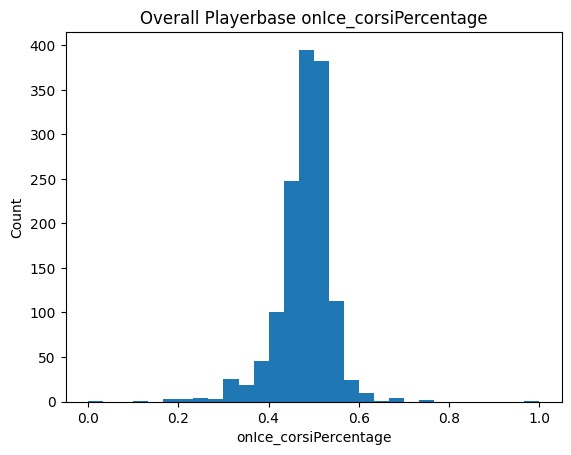

Community:  0
n:  66
mean:  0.4874437685894491
std dev:  0.024866467630856263
Community:  1
n:  63
mean:  0.5062829797350847
std dev:  0.02952885594848233
Community:  2
n:  57
mean:  0.4889910200507862
std dev:  0.02595912960910016
Community:  3
n:  56
mean:  0.4912060825140223
std dev:  0.026918436073314497
Community:  4
n:  55
mean:  0.49732798407169554
std dev:  0.03153609930743365
Community:  5
n:  54
mean:  0.4934685481928597
std dev:  0.033942723406738935
Community:  6
n:  51
mean:  0.49488500992413675
std dev:  0.03466446595184713
Community:  7
n:  50
mean:  0.49235217168125606
std dev:  0.03594546060767132
Community:  8
n:  45
mean:  0.48644304911969777
std dev:  0.029536693505969852
Community:  9
n:  39
mean:  0.491124651398802
std dev:  0.02988086289036685
Community:  10
n:  38
mean:  0.5090006812083461
std dev:  0.027833436865553247
Community:  11
n:  37
mean:  0.5072839956016264
std dev:  0.0392338344923821
Community:  12
n:  36
mean:  0.5095957989697538
std dev:  0.0303581

In [152]:
# Plot corsi influence distribution of entire playerbase
plot_distributions("onIce_corsiPercentage")


In [154]:
# Numeric assortativity between nodes
# Check to see if the positive graph behaves differently than the complete one
def ordinal_stat_assortativity(G, players_df, stat):
    # Copy stat in question as node attribute first
    stats = copy_attr_to_nodes(G, players_df, stat)
    nx.set_node_attributes(G, stats, stat)
    return nx.numeric_assortativity_coefficient(G, attribute=stat)

print(ordinal_stat_assortativity(G, players_df, 'onIce_corsiPercentage'))
print(ordinal_stat_assortativity(G, players_df, 'on_off_corsi_diff'))
print(ordinal_stat_assortativity(G, players_df, 'OnIce_F_goals_per60'))
print(ordinal_stat_assortativity(G, players_df, 'I_F_dZoneGiveaways_per60'))
print(ordinal_stat_assortativity(G, players_df, 'I_F_giveaways_per60'))
print(ordinal_stat_assortativity(G, players_df, 'shotsBlockedByPlayer_per60'))
print(ordinal_stat_assortativity(G, players_df, 'I_F_hits_per60'))
print(ordinal_stat_assortativity(G, players_df, 'I_F_takeaways_per60'))
print(ordinal_stat_assortativity(G, players_df, 'I_F_points_per60'))
print(ordinal_stat_assortativity(G, players_df, 'average_TOI'))

0.41543297221445546
0.30281629816296396
0.43756860734769126
0.23105812122196892
0.2097989272291843
0.11807608225629788
0.18243093475166217
0.14788380015237662
0.32609041915958903
0.34409066042769054
